<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Metalearners Estimators: Use Cases and Examples

Metalearners are binary treatment CATE estimators that model the response surfaces, $Y(0)$ and $Y(1)$, separately. To account for a heterogeneous propensity of treatment $P(T\mid X)$, the two modeled responses $E(Y(0)\mid X)$ and $E(Y(1)\mid X)$ are weighted in different ways in the final CATE estimation. For a detailed overview of these methods, see [this paper](https://arxiv.org/abs/1706.03461). 

The EconML SDK implements the following `metalearners`:

* T-Learner

* S-Learner

* X-Learner

* DomainAdaptation-Learner

* DoublyRobust-Learner

In this notebook, we compare the performance of these four CATE estimatiors on synthetic data and semi-synthetic data.

**Notebook contents:**

1. Example usage with synthetic data

2. Example usage with semi-synthetic data

In [1]:
# Main imports
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner, DoublyRobustLearner

# Helper imports 
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Example Usage with Synthetic Data

### 1.1. DGP

We use the data generating process (DGP) from [Kunzel et al.](https://arxiv.org/abs/1706.03461). The DGP is described by the following equations:

$
Y = \mu_1(x) \cdot T + \mu_0(x) \cdot (1-T) + \epsilon \\
T \sim Bern(e(x)), \; e(x) = P(T=1|X=x)
$

where 

$
\mu_0(x) = x^T\beta,\; with \;\beta\sim Unif([-3, 3]^d),\; X_i \sim N(0, \Sigma)\\
\mu_1(x) = \mu_0(x) + 8 \mathbb{I}(x_2>0.1) => CATE(x) = 8 \mathbb{I}(x_2>0.1)
$


In [2]:
# Define DGP
def generate_data(n, d, controls_outcome, treatment_effect, propensity):
    """Generates population data for given untreated_outcome, treatment_effect and propensity functions.
    
    Parameters
    ----------
        n (int): population size
        d (int): number of covariates
        controls_outcome (func): untreated outcome conditional on covariates
        treatment_effect (func): treatment effect conditional on covariates
        propensity (func): probability of treatment conditional on covariates
    """
    # Generate covariates
    X = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # Generate treatment
    T = np.apply_along_axis(lambda x: binomial(1, propensity(x), 1)[0], 1, X)
    # Calculate outcome
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treat_effect * T
    return (Y, T, X)

In [3]:
# controls outcome, treatment effect, propensity definitions
def generate_controls_outcome(d):
    beta = uniform(-3, 3, d)
    return lambda x: np.dot(x, beta) + normal(0, 1)
treatment_effect = lambda x: (1 if x[1] > 0.1 else 0)*8
propensity = lambda x: (0.8 if (x[2]>-0.5 and x[2]<0.5) else 0.2)

In [4]:
# DGP constants and test data
d = 5
n = 1000
n_test = 250
controls_outcome = generate_controls_outcome(d)
X_test = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
delta = 6/n_test
X_test[:, 1] = np.arange(-3, 3, delta)

In [5]:
Y, T, X = generate_data(n, d, controls_outcome, treatment_effect, propensity)

### 1.2. Train Estimators

In [6]:
# Instantiate T learner
controls_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
treated_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
T_learner = TLearner(controls_model, treated_model)
# Train T_learner
T_learner.fit(Y, T, X)
# Estimate treatment effects on test data
T_te = T_learner.effect(X_test)

In [7]:
# Instantiate S learner
overall_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
S_learner = SLearner(overall_model)
# Train S_learner
S_learner.fit(Y, T, X)
# Estimate treatment effects on test data
S_te = S_learner.effect(X_test)

In [8]:
# Instantiate X learner
controls_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
treated_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                  min_samples_leaf=int(n/100),
                                                  class_weight='balanced_subsample')
X_learner = XLearner(controls_model=controls_model, treated_model=treated_model, propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y, T, X)
# Estimate treatment effects on test data
X_te = X_learner.effect(X_test)

In [9]:
# Instantiate Domain Adaptation learner
controls_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
treated_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
overall_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                  min_samples_leaf=int(n/100),
                                                  class_weight='balanced_subsample')
DA_learner = DomainAdaptationLearner(controls_model=controls_model, treated_model=treated_model, overall_model=overall_model, 
                  propensity_model=propensity_model)
# Train DA_learner
DA_learner.fit(Y, T, X)
# Estimate treatment effects on test data
DA_te = DA_learner.effect(X_test)

In [10]:
# Instantiate Doubly Robust Learner
outcome_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
pseudo_treatment_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                  min_samples_leaf=int(n/100),
                                                  class_weight='balanced_subsample')

DR_learner = DoublyRobustLearner(outcome_model=outcome_model, pseudo_treatment_model=pseudo_treatment_model,
                  propensity_model=propensity_model)
# Train DR_learner
DR_learner.fit(Y, T, X)
# Estimate treatment effects on test data
DR_te = DR_learner.effect(X_test)

### 1.3. Visual Comparisons

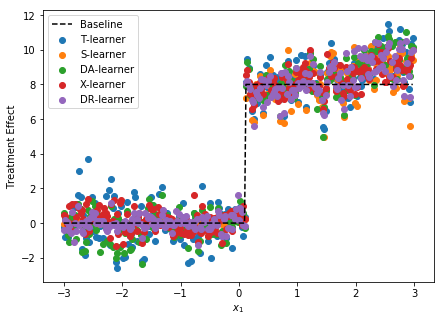

In [11]:
### Comparison plot of the different learners
plt.figure(figsize=(7, 5))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test), color='black', ls='--', label='Baseline')
plt.scatter(X_test[:, 1], T_te, label="T-learner")
plt.scatter(X_test[:, 1], S_te, label="S-learner")
plt.scatter(X_test[:, 1], DA_te, label="DA-learner")
plt.scatter(X_test[:, 1], X_te, label="X-learner")
plt.scatter(X_test[:, 1], DR_te, label="DR-learner")
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

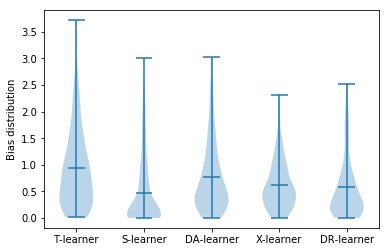

In [12]:
# Visualization of bias distribution
expected_te = np.apply_along_axis(treatment_effect, 1, X_test)
plt.violinplot([np.abs(T_te - expected_te), 
                np.abs(S_te - expected_te),
                np.abs(DA_te - expected_te),
                np.abs(X_te - expected_te),
                np.abs(DR_te - expected_te)
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2, 3, 4, 5], ['T-learner', 'S-learner', 'DA-learner', 'X-learner', 'DR-learner'])
plt.show()

## 2. Example Usage with Semi-synthetic Data

### 2.1. DGP

We use the Response Surface B from [Hill (2011)](https://www.tandfonline.com/doi/pdf/10.1198/jcgs.2010.08162) to generate sythetic outcome surfaces from real-world covariates and treatment assignments (Infant Health Development Program data). Since the original data was part of a randomized trial, a subset of the treated infants (those with non-white mothers) has been removed from the data in order to mimic the observational data setting. For more details, see [Hill (2011)](https://www.tandfonline.com/doi/pdf/10.1198/jcgs.2010.08162).


The DGP is described by the following equations:

$
Y(0) = e^{(X+W)\beta} + \epsilon_0, \;\epsilon_0 \sim N(0, 1)\\
Y(1) = X\beta - \omega + \epsilon_1, \;\epsilon_1 \sim N(0, 1)\\
$

where $X$ is a covariate matrix, $W$ is a constant matrix with entries equal to $0.5$ and $w$ is a constant calculated such that the CATT equals $4$.

In [13]:
from econml.data.dgps import ihdp_surface_B

In [14]:
Y, T, X, expected_te = ihdp_surface_B()

### 2.2. Train Estimators

In [15]:
# T-learner
T_learner.fit(Y, T, X)
T_te = T_learner.effect(X)

In [16]:
# S-learner
S_learner.fit(Y, T, X)
S_te = S_learner.effect(X)

In [17]:
# X-learner
X_learner.fit(Y, T, X)
X_te = X_learner.effect(X)

In [18]:
# Domain adaptation learner
DA_learner.fit(Y, T, X)
DA_te = DA_learner.effect(X)

In [19]:
# Doubly robust learner
DR_learner.fit(Y, T, X)
DR_te = DR_learner.effect(X)

### 2.3. Visual Comparisons

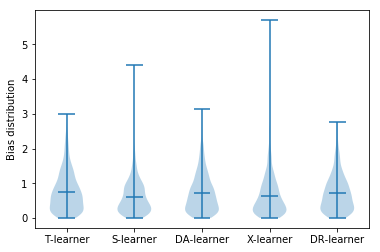

In [20]:
# Visualization of bias distribution
plt.violinplot([np.abs(T_te - expected_te), 
                np.abs(S_te - expected_te),
                np.abs(DA_te - expected_te),
                np.abs(X_te - expected_te),
                np.abs(DR_te - expected_te)
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2, 3, 4, 5], ['T-learner', 'S-learner', 'DA-learner', 'X-learner', 'DR-learner'])
plt.show()